In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
#import torch
import numpy as np
from sklearn.model_selection import train_test_split
#import torch.nn.functional as F

In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def dsigmoid(z):
    h = np.exp(-z)
    return -h/(1+h)**2
    #return -np.exp(-z)/(1+np.exp(-z))**22

def fLR(w, x, y):
    h = sigmoid(x @ w)
    eps = 1e-4
    return (- y @ np.log(h + eps) - (1 - y) @ np.log(1 - h + eps)) / y.shape[0]

def dfLR(w, x, y):
    h = sigmoid(x @ w)
    return x.T @ (h - y) / y.shape[0]

def d2fLR(w, x, y):
    h = sigmoid(x @ w)
    return (x.T * (h * (1 - h))) @ x / y.shape[0]

def fInner(w, lam, x, y):
    return fLR(w, x, y) + w @ ((1e-4 + lam ** 2) * w) / w.shape[0]
    #return fLR(w, x, y) + w @ ((1e-4 + np.exp(lam)) * w) / w.shape[0]
    #return fLR(w, x, y) + w @ (lam * w)

def dfInner(w, lam, x, y):
    # d/dw
    return dfLR(w, x, y) + 2 * (1e-4 + lam ** 2) * w / w.shape[0]
    #return dfLR(w, x, y) + 2 * (1e-4 + np.exp(lam)) * w / w.shape[0]
    #return dfLR(w, x, y) + 2 * lam * w

def d2fInner(w, lam, x, y):
    # d2/dw2, d2/dwdlam
    return (d2fLR(w, x, y) + 2 * np.diag(1e-4 + lam ** 2) / w.shape[0], 4 * np.diag(lam * w) / w.shape[0])
    #return (d2fLR(w, x, y) + 2 * np.diag(1e-4 + np.exp(lam)) / w.shape[0], 2 * np.diag(np.exp(lam) * w) / w.shape[0])
    #return d2fLR(w, x, y) + 2 * np.diag(lam), 2 * np.diag(w)

In [10]:
def fOuter(w, x, y):
    return fLR(w, x, y)

def dfOuter(w, x, y):
    return dfLR(w, x, y)

In [11]:
# synthetic data generation
seed = 2021
n, d = 2000, 200
val_perc = 0.2
np.random.seed(seed)

w_oracle = np.random.randn(d)
x = np.random.randn(n, d)
y = x @ w_oracle + 10 * np.random.randn(n)
y = (y > 0.).astype(float) # binary classification output

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_perc)
print(x_train.shape)
print(x_val.shape)

(1600, 200)
(400, 200)


In [12]:
y1 = x @ w_oracle
y1 = (y1 > 0.).astype(float)
print(sum(np.abs(y - y1)))

393.0


In [95]:
# hyper parameters
epochmax = 500
bs = 20
itermax = x_train.shape[0] // bs
lr_in = 0.1
lr_out = 0.1
tau = 0.1


# initial parameters
seed = 1234
w0 = np.random.randn(d)
lam0 = 0.1*np.ones(d) # np.zeros(d) #
H1 = np.identity(d)
H2 = np.zeros((d, d))
L_g = 0.25 * np.linalg.eigvals(x_train.T @ x_train).max() / x_train.shape[0] + 2 * (1e-4 + lam0.max()**2)

In [96]:
np.random.seed(seed)
record_loss = []
w = w0
lam = lam0
for epoch in range(epochmax):
    #idx = np.arange(x_train.shape[0])
    #np.random.shuffle(idx)
    for i in range(itermax):
        #s = idx[i * bs : (i+1) * bs]
        s = np.random.choice(x_train.shape[0], size=bs)
        w = w - lr_in * dfInner(w, lam, x_train[s,:], y_train[s])
    
    record_loss.append(fOuter(w, x_val, y_val))
    
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.6705773639235661
0.36030456294990276


In [183]:
def my_solve(H, v): # solve Hw = v for w
    c = 0.9/L_g#1.0/np.linalg.eigvalsh(H).max()#0.9/L_g#H.diagonal().max()#np.linalg.eigvalsh(H).max()#0.5/L_g#L_g#
    w = np.copy(v)
    for _ in range(10):
        v = v - c * H @ v
        w += v    
    return c*w
#def my_solve(H, v):
#    return np.linalg.solve(H, v)

In [184]:
record_loss_our = []
w = w0
lam = lam0
tau = 0.1
H1 = np.identity(d) 
H2 = np.zeros((d, d))

In [185]:
# STABLE
np.random.seed(seed)
for epoch in range(epochmax):
    for i in range(itermax):  
        s = np.random.choice(x_val.shape[0], size=bs)
        # outer loop
        lam_p = lam
        lam = lam + lr_out * H2 @ my_solve(H1, dfOuter(w, x_val[s,:], y_val[s]))
        #lam -= 1e-4
        #lam = lam * (lam > 0.).astype(float)
        #lam += 1e-4
        
        # inner loop
        w_p = w
        w = w - lr_in * dfInner(w, lam_p, x_train[s,:], y_train[s]) - my_solve(H1, (H2.T @ (lam - lam_p)))
    
        # update H1, H2
        s = np.random.choice(x_train.shape[0], size=bs)
        h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
        h1_p, _ = d2fInner(w_p, lam_p, x_train[s,:], y_train[s])
        s = np.random.choice(x_train.shape[0], size=bs)
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        _, h2_p = d2fInner(w_p, lam_p, x_train[s,:], y_train[s])
        H1 = (1 - tau) * (H1 - h1_p) + h1
        H2 = (1 - tau) * (H2 - h2_p) + h2
    
    #eigs, eigv = np.linalg.eigh(H1)
    #eigs = np.maximum(eigs, 1e-4)
    #H1 = eigv @ (eigs[:, np.newaxis] * eigv.T)  
    #H2 = np.maximum(np.minimum(H2, 1), -1)
    record_loss_our.append(fOuter(w, x_val, y_val))
    
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

<ipython-input-9-cf2aa321b68a>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))
<ipython-input-183-9bbe0ec59673>:5: RuntimeWarning: overflow encountered in matmul
  v = v - c * H @ v
<ipython-input-183-9bbe0ec59673>:5: RuntimeWarning: invalid value encountered in matmul
  v = v - c * H @ v
<ipython-input-9-cf2aa321b68a>:35: RuntimeWarning: overflow encountered in square
  return (d2fLR(w, x, y) + 2 * np.diag(1e-4 + lam ** 2) / w.shape[0], 4 * np.diag(lam * w) / w.shape[0])
<ipython-input-9-cf2aa321b68a>:35: RuntimeWarning: overflow encountered in multiply
  return (d2fLR(w, x, y) + 2 * np.diag(1e-4 + lam ** 2) / w.shape[0], 4 * np.diag(lam * w) / w.shape[0])
<ipython-input-9-cf2aa321b68a>:29: RuntimeWarning: overflow encountered in square
  return dfLR(w, x, y) + 2 * (1e-4 + lam ** 2) * w / w.shape[0]
<ipython-input-9-cf2aa321b68a>:29: RuntimeWarning: overflow encountered in multiply
  return dfLR(w, x, y) + 2 * (1e-4 + lam ** 2) * w / w.shape[0]


nan
nan


In [123]:
# STABLE no tracking
np.random.seed(seed)
for epoch in range(epochmax):
    for i in range(itermax):  
        s = np.random.choice(x_val.shape[0], size=bs)
        # outer loop
        lam_p = lam
        lam = lam + lr_out * H2 @ my_solve(H1, dfOuter(w, x_val[s,:], y_val[s]))
        #lam -= 1e-4
        #lam = lam * (lam > 0.).astype(float)
        #lam += 1e-4
        
        # inner loop
        w_p = w
        w = w - lr_in * dfInner(w, lam_p, x_train[s,:], y_train[s]) - my_solve(H1, (H2.T @ (lam - lam_p)))
    
        # update H1, H2
        s = np.random.choice(x_train.shape[0], size=bs)
        h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
        #h1_p, _ = d2fInner(w_p, lam_p, x_train[s,:], y_train[s])
        s = np.random.choice(x_train.shape[0], size=bs)
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        #_, h2_p = d2fInner(w_p, lam_p, x_train[s,:], y_train[s])
        H1 = h1#(1 - tau) * (H1 - h1_p) + h1
        H2 = h2#(1 - tau) * (H2 - h2_p) + h2
    
    #eigs, eigv = np.linalg.eigh(H1)
    #eigs = np.maximum(eigs, 1e-4)
    #H1 = eigv @ (eigs[:, np.newaxis] * eigv.T)  
    #H2 = np.maximum(np.minimum(H2, 1), -1)
    record_loss_our.append(fOuter(w, x_val, y_val))
    
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

<ipython-input-9-cf2aa321b68a>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-z))


KeyboardInterrupt: 

In [143]:
print(np.linalg.eigvalsh(H1).max())
print(L_g)

0.7562791461747167
0.47300108871781427


In [107]:
# hong increasing batch size
record_loss_hong = []
record_s = []
w = w0
lam = lam0
num_s = 0
np.random.seed(seed)
for epoch in range(epochmax):
    for i in range(itermax): 
        s = np.random.choice(x_val.shape[0], size=bs)
        num_s += bs
        # outer loop
        lam_p = lam
        t = int(np.log(epoch + 1)) + 1
        p = np.random.randint(t)
        num_s += p * bs
        hg = dfOuter(w, x_val[s,:], y_val[s])
        for j in range(p):
            s = np.random.choice(x_train.shape[0], size=bs)
            h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
            hg = hg - 1/L_g * (h1 @ hg)
        hg = hg * (t/L_g)
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        
        lam = lam + (lr_out * (epoch + 1)**(0)) * h2 @ hg #-3/5
        
        #lam -= 1e-4
        #lam = lam * (lam > 0.).astype(float)
        #lam += 1e-4
        
        # inner loop
        w_p = w
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        w = w - (lr_in * (epoch + 1)**(0)) * dfInner(w, lam, x_train[s,:], y_train[s])#-2/5
    
        record_s.append(num_s)    
        record_loss_hong.append(fOuter(w, x_val, y_val))
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.4653672259093621
0.45282554105379735


In [29]:
# stocBio
record_loss_stocbio = []
record_s_stocbio = []
w = w0
lam = lam0
np.random.seed(seed)
T = 5
bs = 20
num_s = 0
for epoch in range(epochmax):
    for i in range(itermax):
        # inner loop
        for t in range(T):
            s = np.random.choice(x_train.shape[0], size=bs)
            num_s += bs
            w = w - lr_in * dfInner(w, lam, x_train[s,:], y_train[s])
        # outer loop
        lam_p = lam
        Q = int(np.log(epoch + 1)) + 1
        num_s += Q * bs
        s = np.random.choice(x_val.shape[0], size=bs)
        hg = dfOuter(w, x_val[s,:], y_val[s])
        vQ = np.copy(hg)
        for j in range(Q):
            s = np.random.choice(x_train.shape[0], size=bs)
            h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
            hg = hg - 1/L_g * (h1 @ hg)
            vQ += hg
        hg = vQ * (1/L_g)#hg * (t/L_g)
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        
        lam = lam + (lr_out * (epoch + 1)**(0)) * h2 @ hg #-3/5
        
        #lam -= 1e-4
        #lam = lam * (lam > 0.).astype(float)
        #lam += 1e-4
    
        record_s_stocbio.append(num_s)    
        record_loss_stocbio.append(fOuter(w, x_val, y_val))
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.46053573897309363
0.44486040360267254


In [30]:
# hong fixed batch size
record_loss_hong1 = []
record_s_hong1 = []
w = w0
lam = lam0
np.random.seed(seed)
num_s = 0
for epoch in range(epochmax):
    for i in range(itermax): 
        s = np.random.choice(x_val.shape[0], size=bs)
        num_s += bs
        # outer loop
        lam_p = lam
        t, p = 2, 1
        hg = dfOuter(w, x_val[s,:], y_val[s])
        for j in range(p):
            s = np.random.choice(x_train.shape[0], size=bs)
            num_s += bs
            h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
            hg = hg - 1/L_g * (h1 @ hg)
        hg = hg * (t/L_g)
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        
        lam = lam + (lr_out * (epoch + 1)**(0)) * h2 @ hg #-3/5
        
        #lam -= 1e-4
        #lam = lam * (lam > 0.).astype(float)
        #lam += 1e-4
        
        # inner loop
        w_p = w
        s = np.random.choice(x_train.shape[0], size=bs)
        w = w - (lr_in * (epoch + 1)**(0)) * dfInner(w, lam, x_train[s,:], y_train[s])#-2/5
        record_loss_hong1.append(fOuter(w, x_val, y_val))
        record_s_hong1.append(num_s)
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.5058223226683044
0.4195902343637753


In [31]:
# wang increasing batch size
record_loss_wang = []
record_s_wang = []
w = w0
lam = lam0
num_s = 0
np.random.seed(seed)
for epoch in range(epochmax):
    for i in range(itermax): 
        s = np.random.choice(x_val.shape[0], size=bs)
        num_s += bs
        # outer loop
        lam_p = lam
        t = np.ceil((np.log(epoch + 1))) + 1
        p = np.random.randint(t)
        num_s += p * bs
        hg = dfOuter(w, x_val[s,:], y_val[s])
        for j in range(p):
            s = np.random.choice(x_train.shape[0], size=bs)
            h1, _ = d2fInner(w, lam, x_train[s,:], y_train[s])
            hg = hg - 1/L_g * (h1 @ hg)
        hg = hg * (t/L_g)
        s = np.random.choice(x_train.shape[0], size=bs)
        num_s += bs
        _, h2 = d2fInner(w, lam, x_train[s,:], y_train[s])
        
        lam = lam + (lr_out * (epoch + 1)**(0)) * h2 @ hg #-3/5
        
        #lam -= 1e-4
        #lam = lam * (lam > 0.).astype(float)
        #lam += 1e-4
        
        # inner loop
        for t in range(np.ceil(np.sqrt(epoch + 1)).astype(int)):
            w_p = w
            s = np.random.choice(x_train.shape[0], size=bs)
            w = w - (lr_in / (epoch + 1)) * dfInner(w, lam, x_train[s,:], y_train[s])#-2/5
        num_s += bs * (t+1)
    
        record_s_wang.append(num_s)    
        record_loss_wang.append(fOuter(w, x_val, y_val))
print(fOuter(w, x_val, y_val))
print(fInner(w, lam, x_train, y_train))

0.4476418688155488
0.413569236898266


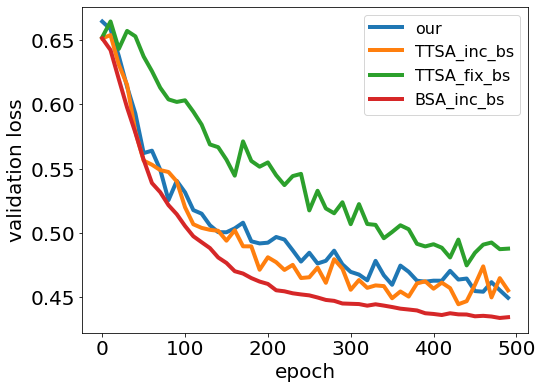

In [624]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))#(figsize=(6.4, 5.6))
#plt.plot(np.arange(epochmax)[::10], record_loss[::10])
plt.plot(np.arange(epochmax)[::10], record_loss_our[::10])
plt.plot(np.arange(epochmax)[::10], record_loss_hong[::10])
plt.plot(np.arange(epochmax)[::10], record_loss_hong1[::10])
plt.plot(np.arange(epochmax)[::10], record_loss_wang[::10])
plt.legend(["our", "TTSA_inc_bs", "TTSA_fix_bs", "BSA_inc_bs"],fontsize=16)
plt.xlabel("epoch")
plt.ylabel("validation loss")
fig.savefig('bilevel_epoch.pdf', bbox_inches='tight', dpi=fig.dpi)

ValueError: x and y must have same first dimension, but have shapes (50,) and (100,)

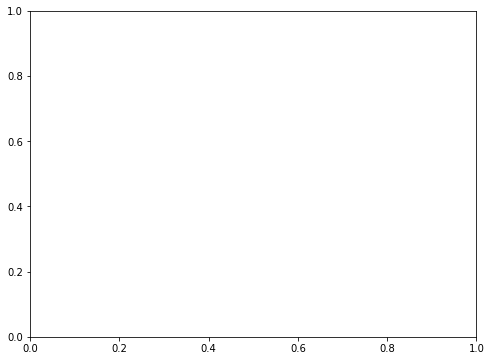

In [148]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))#(figsize=(6.4, 5.6))
#plt.plot(np.arange(epochmax)[::10]*30*bs, record_loss[::10])
plt.plot(np.arange(epochmax)[::10]*40*bs, record_loss_our[::10])
plt.plot(record_s[::10], record_loss_hong[::10])
plt.plot(np.arange(epochmax)[::10]*40*bs, record_loss_hong1[::10])
plt.plot(record_s_wang[::10], record_loss_wang[::10])
plt.plot(record_s_stocbio[::10], record_loss_stocbio[::10])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(["our", "TTSA_inc_bs", "TTSA_fix_bs", "BSA_inc_bs", "stocBio"], fontsize=16, loc=3)
plt.xlim([0, 1e5])
plt.xlabel("sample")
plt.ylabel("validation loss")
fig.savefig('bilevel_sample.pdf', bbox_inches='tight', dpi=fig.dpi)

In [230]:
print(record_s[1])

[969 699 872 398 917 880 912 341 336 835 737  40  10 681 128 208 163 602
 548 446]


In [354]:
print(lam)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


In [385]:
a = np.linalg.lstsq(np.random.randn(10, 20), np.random.randn(10))[0]
print(a.shape)

(20,)


<ipython-input-385-11817b445ca6>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(np.random.randn(10, 20), np.random.randn(10))[0]


In [429]:
A = np.random.randn(10,10)
A = A + A.T
eigs, eigv = np.linalg.eigh(A)

In [443]:
print(np.linalg.norm(A - (eigv @ (eigs[:, np.newaxis] * eigv.T))))

1.808545579411944e-14
